# Gangseo-gu Park Data Collecting
- 강서구의 151개의 공원정보가 담긴 행들과
- 각 공원의 value값을 결정할 변수들이 담긴 열들을 만드는 것이 목적입니다
- 수집된 데이터로 kruskal 알고리즘을 사용하여 최적의 선형공원을 제시합니다

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from haversine import haversine
import folium
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from geopy.distance import geodesic
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
import re
import math
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')
%matplotlib inline

## Park data Loading

In [2]:
# 데이터 로딩
data =pd.read_csv("./data/서울특별시_강서구_도시공원정보_20230310.csv", encoding = "cp949") 
df = data.copy()

# 필요없는 열 드랍
df.drop(columns =['관리번호','소재지도로명주소', # '소재지지번주소',
                 '관리기관명','전화번호','데이터기준일자','지정고시일'], inplace = True)
# 열이름 변경
df = df.rename(columns={'공원명': '이름', '공원구분': '구분', '공원면적':'면적'})

df.head()

,이름,구분,소재지지번주소,위도,경도,면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설)
0,우장,근린공원,서울특별시 강서구 화곡동 산60-1,37.552820,126.843808,359435.2,농구장+배드민턴장+축구장+테니스장+족구장,NaN,주차장+화장실+음수대,NaN,NaN
1,궁산,근린공원,서울특별시 강서구 가양동 산4-7,37.574254,126.841332,135002.7,다목적체육관,NaN,화장실+음수대,NaN,NaN
2,염창,근린공원,서울특별시 강서구 염창동 산24-1,37.557765,126.868792,112070.0,배드민턴장,NaN,화장실,NaN,NaN
3,꿩고개,근린공원,서울특별시 강서구 방화동 산97-1,37.578139,126.816895,180000.0,게이트볼장,NaN,화장실,NaN,NaN
4,봉제산,근린공원,서울특별시 강서구 화곡동 산1,37.540731,126.858825,917190.0,NaN,수경시설,화장실+음수대,NaN,NaN


In [3]:
# 공원면적 별로 유치거리 구분하기 
# 근린공원 중에 면적이 1940인게 있지만 그것도 면적기반으로 처리함
def park_distance(m2): 
    if m2 < 10000 : return 250 # 10000 미만 -> 250미터
    elif 10000<= m2 < 30000 : return 500 # 10000~30000 -> 500미터
    else : return 1000 # 30000~ -> 1000미터

#유치거리에 공원면적을 포함 안시키기 위해 면적 기반으로 정사각형 반지름 만큼 유치거리에 합하기 용
df['유치거리'] = (df['면적'].apply(math.sqrt))/2 
for park in df['구분'].unique():
    df['유치거리'][df['구분']==park] += df[df['구분']==park]['면적'].apply(park_distance)


## Data Preprocessing

### 위도 경도 값을 네이버, 카카오, 구글 지도와 대조하여 실제 값으로 수정

#### 행정동 구분하기(by 위경도 좌표)

In [4]:
seoul = gpd.read_file("./data/Z_SOP_BND_ADM_DONG_PG/Z_SOP_BND_ADM_DONG_PG.shp",encoding='cp949')

hd = ['가양1동','가양2동','가양3동','공항동','등촌1동','등촌2동','등촌3동',
      '발산1동','방화1동','방화2동','방화3동','염창동','우장산동',
      '화곡1동','화곡2동','화곡3동','화곡4동','화곡6동','화곡8동','화곡본동']
for i in range(len(seoul)):
    if seoul.ADM_DR_NM[i] not in hd :
        seoul.drop(index = i ,inplace = True)
seoul.drop(index = [1028, 1029],inplace= True)
seoul = seoul[['ADM_DR_NM','geometry']]
seoul = seoul.to_crs(epsg=4326)

dong_cordi = dict()
dong = seoul['ADM_DR_NM'].values
cordi = seoul['geometry'].values
for i in range(len(seoul['ADM_DR_NM'].values)):
    dong_cordi[dong[i]] = cordi[i]
display(dong_cordi)

{'염창동': <POLYGON ((126.873 37.56, 126.874 37.559, 126.874 37.559, 126.875 37.559, 12...>,
 '등촌1동': <POLYGON ((126.865 37.551, 126.865 37.551, 126.865 37.551, 126.865 37.551, 1...>,
 '등촌2동': <POLYGON ((126.863 37.552, 126.864 37.551, 126.864 37.551, 126.864 37.551, 1...>,
 '등촌3동': <POLYGON ((126.846 37.565, 126.846 37.565, 126.847 37.565, 126.847 37.565, 1...>,
 '화곡본동': <POLYGON ((126.848 37.549, 126.849 37.549, 126.849 37.548, 126.849 37.548, 1...>,
 '화곡2동': <POLYGON ((126.855 37.536, 126.855 37.536, 126.855 37.536, 126.855 37.536, 1...>,
 '화곡3동': <POLYGON ((126.836 37.548, 126.836 37.548, 126.836 37.547, 126.836 37.547, 1...>,
 '화곡4동': <POLYGON ((126.857 37.542, 126.858 37.542, 126.858 37.542, 126.858 37.542, 1...>,
 '화곡6동': <POLYGON ((126.857 37.552, 126.857 37.552, 126.858 37.552, 126.858 37.552, 1...>,
 '화곡8동': <POLYGON ((126.852 37.539, 126.852 37.539, 126.852 37.538, 126.852 37.538, 1...>,
 '가양1동': <POLYGON ((126.835 37.584, 126.836 37.583, 126.836 37.583, 126.837 37.583, 1...>,


In [5]:
# 공원 데이터에 행정동 구분이 되어있지 않으므로 folium 경계를 이용하여 공원의 행정동 재분류
temp_df = df[['위도','경도']] #행정동체크를 위한 임시 dataframe 생성
for i in range(len(dong)): 
    temp_df[dong[i]] = np.nan

for d in dong:
    for i in range(len(temp_df)):#공원의 위경도가 행정동안에 있는지 체크
        if dong_cordi[d].contains(Point(temp_df['경도'][i],temp_df['위도'][i])): 
            temp_df[d][i] = 1

temp_df["행정동명"] = np.nan
for d in dong: #df에 행정동이름 추가하는 과정
    temp_df["행정동명"][temp_df[d] == 1] = d
df["행정동명"] = temp_df["행정동명"]

### 공원데이터 수작업 비교
수작업 핵심 : 네이버지도와 데이터에 모두 존재하는 공원 중 위경도가 잘못 되어있는 데이터만 수정한다
<br> 수작업 방법 : Naver Geocoding API를 이용하여 지번주소로 위경도 재탐색, 주소가 잘못되어있는지 수작업으로 판단 후 수정

- 수작업 중 발견한 문제들:
    1. 공원데이터에 없는 데이터가 네이버에 있기도 하고 그 반대도 있었다
    <br>하지만 공원데이터가 지극히 소규모 공원을 제외하고는 거의 전부 있었다. 또한 데이터에는 있는데 네이버지도에 안나오는 공원 중 대다수가 검색하면 최신 블로그에 나왔다. 따라서 이러한 문제 함부로 처리할 수 없지만 굳이 처리하지 않아도 결과에 커다란 영향을 주지 않는다고 판단했다
    2. 위치 정보가 크게 잘못된 경우 : 직접 위경도를 찾아 수정하는 과정을 거쳤다
    3. 위경도 정보가 동일하지만 이름만 잘못된 경우 : 본 프로젝트에서 공원명은 중요하지 않아 굳이처리 하지 않았지만 최종 결과 해석에 있어서 헷갈릴 수 있으므로 목록만 정리해두었다
        - 근린공원(방화2) = 민들레(방화2)
        - 이름없음 = 봉선화(방화2)
        - 우장산힐스테이트아파트공원 = 꿈빛어린이공원
        - 대림경동아파트 공원 = 엄지어린이공원(가양2)
        - 가로공원 = 은행어린이 공원(화곡1)


<br>

데이터에는 있는데 네이버지도에는 없는 것: -> 검색해보면 나오긴한다 일단 있다고 가정
- 염창동 : 염창2소공원 OK
- 등촌3동 : 한마음, 매화 OK 
- 화곡본동 : 참새어린이공원 OK 
- 화곡3동 : 푸른수명산소공원 OK
- 화곡6동 : 등마루 근린공원 OK
- 가양1동 : 꽃동네어린이, 가양어린이,  OK
- 가양3동 : 곰돌이 어린이공원, OK
- 발산1동 : 솔어린이공원, 햇빛어린이공원 OK
- 우장산동 : 가곡어린이공원, 화곡3주구1 어린이공원 OK
- 공항동 : 송정어린이공원 OK
- 방화2동 : 개화공원?? OK
- 방화3 : 능말어린이,개화어린이 OK 
- 방화1 : 새싺, 개나리 ,문성, 들꽃, 긴등마을OK

네이버지도에는 있는데 데이터에 없는 것 
- 등촌2동 : 백석마을마당, 봉제산숲속놀이터 
- 화곡본동 :  봉제산근린공원, 
- 공항동 : (송정?)근린공원
- 방화1동 :은하수

<br>

@ 방화123동을 중심으로 다시보기


In [6]:
# 잘못된 주소 수정
df['소재지지번주소'][df['이름'] == '신대부석'] = '서울 강서구 개화동 411'
df['소재지지번주소'][df['이름'] == '내촌'] = '서울특별시 강서구 개화동 551-34'
df['소재지지번주소'][df['이름'] == '은행나무'] = '서울 강서구 개화동 458'
df['소재지지번주소'][df['이름'] == '다솜'] = '서울특별시 강서구 마곡동 742-2' #인근 지형 주소로 대체
df['소재지지번주소'][df['이름'] == '광명'] = '서울특별시 강서구 외발산동 221-1' #인근 지형 주소로 대체
# df['소재지지번주소'][df['이름'] == '새싹'] 

In [7]:
from urllib.request import urlopen
from urllib import parse
from urllib.request import Request
from urllib.error import HTTPError
from bs4 import BeautifulSoup
import json

#naver map api key
client_id = 'bk2ucmsgyp';    # 본인이 할당받은 ID 입력
client_pw = 'qE7Eo7ZIoHsUNXUF5XwsKhJOpSxrdod9bIOYO6xD';    # 본인이 할당받은 Secret 입력

api_url = 'https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?query='


# 네이버 지도 API 이용해서 위경도 찾기
geo_coordi = []     
for add in df['소재지지번주소']:
    temp_df = df[df['소재지지번주소'] == add]
    add_urlenc = parse.quote(add)  
    url = api_url + add_urlenc
    request = Request(url)
    request.add_header('X-NCP-APIGW-API-KEY-ID', client_id)
    request.add_header('X-NCP-APIGW-API-KEY', client_pw)
    try:
        response = urlopen(request)
    except HTTPError as e:
        print('HTTP Error!')
        latitude = None
        longitude = None
    else:
        rescode = response.getcode()
        if rescode == 200:
            response_body = response.read().decode('utf-8')
            response_body = json.loads(response_body)   # json
            if response_body['addresses'] == [] :
                print("'result' not exist!")
                latitude = None
                longitude = None
                display(df[df['소재지지번주소'] == add])
            else:
                latitude = response_body['addresses'][0]['y']
                longitude = response_body['addresses'][0]['x']
                df['위도'][df['소재지지번주소'] == add] = latitude
                df['경도'][df['소재지지번주소'] == add] = longitude 
                # print("Success!")
        else:
            print('Response error code : %d' % rescode)
            latitude = None
            longitude = None

    geo_coordi.append([latitude, longitude])

In [8]:
# 위도 경도 데이터타입 수정
df['위도'] = df['위도'].astype('float')
df['경도'] = df['경도'].astype('float')

# 위경도 리스트
park_loc = list()
for  i in range(len(df)):
    loc = [df['위도'][i],df['경도'][i]]
    park_loc.append(loc)
park_loc

[[37.5504021, 126.8435599],
 [37.5741566, 126.8407987],
 [37.5579009, 126.8688619],
 [37.5781568, 126.816935],
 [37.5410899, 126.8586256],
 [37.5880634, 126.8055269],
 [37.5525649, 126.855165],
 [37.5699353, 126.8503191],
 [37.5678012, 126.8526841],
 [37.5617043, 126.8644805],
 [37.5597905, 126.8420214],
 [37.5634135, 126.8417701],
 [37.5586003, 126.8500101],
 [37.580923, 126.8144765],
 [37.5739069, 126.8210288],
 [37.5574866, 126.8609687],
 [37.5367447, 126.8440782],
 [37.5496218, 126.82771],
 [37.5549805, 126.8253733],
 [37.5698035, 126.8318322],
 [37.5662108, 126.8218603],
 [37.5567812, 126.821647],
 [37.5482766, 126.8743826],
 [37.551178, 126.8694814],
 [37.5516964, 126.8752946],
 [37.5591611, 126.8546445],
 [37.5526349, 126.863493],
 [37.5560605, 126.8574168],
 [37.5556054, 126.8628886],
 [37.5465002, 126.8600832],
 [37.5606742, 126.8431025],
 [37.5615734, 126.8520333],
 [37.5592628, 126.8450084],
 [37.5627653, 126.8460591],
 [37.5590626, 126.8475085],
 [37.5607124, 126.840299],
 

In [9]:
# 위경도 리스트
park_loc2 = list()
for  i in range(len(data)):
    loc = [data['위도'][i],data['경도'][i]]
    park_loc2.append(loc)
park_loc2

center = park_loc[0]
g_map = folium.Map(location=park_loc[0], zoom_start=11, tiles='cartodbpositron')

for i in range(len(df)):
    folium.Marker(park_loc[i], popup = df['소재지지번주소'][i],tooltip = df['이름'][i]).add_to(g_map)
for i in range(len(data)):
    folium.Marker(park_loc2[i], popup = df['소재지지번주소'][i],tooltip = df['이름'][i],icon = folium.Icon(color= 'red')).add_to(g_map)
for dong in dong_cordi:
    if True: #dong == '방화1동':
        folium.GeoJson(data=dong_cordi[dong].__geo_interface__, tooltip = dong).add_to(g_map)
# g_map.save('output/map1.html')
g_map # 대조 결과 : API를 사용해서 데이터가 문제가 생기는 부분은 없음.(크게 다른 부분들은 직접 수정하거나 큰 공원인 경우임)

In [10]:
# 추가로 위도_경도로 아이디 값 생성
df['id'] = df['위도'].apply(lambda x: str(x)) + "_"+df['경도'].apply(lambda x: str(x))

# 위도 경도 데이터타입 수정
df['위도'] = df['위도'].astype('float')
df['경도'] = df['경도'].astype('float')

### 보유시설수 columns 생성

In [11]:
facility = ['공원보유시설(운동시설)','공원보유시설(유희시설)',
            '공원보유시설(편익시설)', '공원보유시설(기타시설)','공원보유시설(교양시설)']
for fac in facility: # +로 붙어있던 문자열을 list로 구분하고 데이터 확인용 루프
    try : display(df[fac].str.split('+').value_counts())
    except : display(df[fac].value_counts()) #전부 결측치

for fac in facility: # +로 붙어있던 문자열을 list로 구분하고 개수로 값을 대체
    df[fac].fillna('', inplace = True)
    df[fac] = df[fac].str.split('+').apply(lambda x : len(x) if len(x[0]) != 0 else 0)

# 개수를 더해 보유시설수 columns 생성
df['보유시설수'] = df[facility].sum(axis=1) 
df.drop(columns = facility, inplace = True)
df.head(2)

[운동기구]                          5
[농구장]                           4
[게이트볼장]                         2
[농구장, 배드민턴장, 축구장, 테니스장, 족구장]    1
[다목적체육관]                        1
[배드민턴장]                         1
[농구장, 배드민턴장, 족구장]               1
[농구장, 배드민턴장, 풋살장, 테니스장, 족구장]    1
[농구장, 다목적구장]                    1
[농구장, 족구장, 배드민턴장]               1
[농구장, 족구장, 다목적구장]               1
[배드민턴장, 테니스장, 다목적체육관]           1
Name: 공원보유시설(운동시설), dtype: int64

[어린이놀이시설]          101
[수경시설, 어린이놀이시설]     11
[수경시설]               6
Name: 공원보유시설(유희시설), dtype: int64

[음수대]              26
[화장실, 음수대]         16
[화장실]              15
[주차장, 화장실, 음수대]     1
[화장실, 매점, 주차장]      1
Name: 공원보유시설(편익시설), dtype: int64

[식물원(온실)]    1
Name: 공원보유시설(기타시설), dtype: int64

Series([], Name: 공원보유시설(교양시설), dtype: int64)

,이름,구분,소재지지번주소,위도,경도,면적,유치거리,행정동명,id,보유시설수
0,우장,근린공원,서울특별시 강서구 화곡동 산60-1,37.550402,126.843560,359435.2,1299.764574,우장산동,37.5504021_126.8435599,8
1,궁산,근린공원,서울특별시 강서구 가양동 산4-7,37.574157,126.840799,135002.7,1183.713568,가양1동,37.5741566_126.8407987,3


### 지하철 접근도

In [12]:
# 서울시 지하철 역사 마스터 정보 로딩
subway_data =pd.read_csv("./data/서울시 역사마스터 정보.csv", encoding = "cp949") 
subway_data.columns = ['역사_ID', '역사명', '호선', '경도','위도']
subway_data= subway_data.replace('신정(은행정)','신정') # 다른 이름이지만 같은 데이터 처리
df= df.replace('신정(은행정)','신정')

# 승하차 유동인구 데이터
df_c =pd.read_csv("./data/지하철역_사람수나눔_승차하차정보.csv") 
df_c = df_c.rename(columns = {'지하철역':'역사명'})
df_c['승하차유동인구합'] = df_c['oAll']+df_c['dAll']

# 지하철역 노선 정리
subway_data = subway_data[subway_data['역사명'].isin(df_c['역사명'].values.tolist())]

for line in subway_data['호선'].unique():#호선 정보를 열로
    subway_data[line] = 0
    subway_data[line][subway_data['호선']==line] = 1

# 각 역사명을 하나로 합치면서 호선 정보도 한번에 합침
join_df = subway_data.groupby('역사명')['김포골드라인', '공항철도1호선', '9호선', '5호선'].sum()
unique_sub = subway_data.drop(columns = ['호선','김포골드라인', '공항철도1호선', '9호선', '5호선']).\
                            drop_duplicates(subset='역사명')
subway_data = pd.merge(left = unique_sub , right = join_df, how = "inner", on = "역사명")
subway_data['노선수'] = subway_data[['김포골드라인', '공항철도1호선', '9호선', '5호선']].sum(axis = 1)

# 한번에 합쳐서 최종 만들기
subway_data = pd.merge(left = subway_data , right = df_c[['역사명','승하차유동인구합']],\
                       how = "inner", on = "역사명")

subway_data["위경도"] = [(float(subway_data['위도'].values[i]),float(subway_data['경도'].values[i])) \
                      for i in range(len(subway_data))]

subway_data

,역사_ID,역사명,경도,위도,김포골드라인,공항철도1호선,9호선,5호선,노선수,승하차유동인구합,위경도
0,4929,김포공항,126.801868,37.562360,1,1,1,1,4,46110.524675,"(37.56236, 126.801868)"
1,4206,마곡나루,126.827378,37.565543,0,1,1,0,2,1506.741991,"(37.565543, 126.827378)"
2,4110,염창,126.874916,37.546936,0,0,1,0,1,28411.395671,"(37.546936, 126.874916)"
3,4109,등촌,126.865689,37.550632,0,0,1,0,1,18334.654545,"(37.550632, 126.865689)"
4,4108,증미,126.861939,37.557402,0,0,1,0,1,11734.532468,"(37.557402, 126.861939)"
5,4107,가양,126.854456,37.561391,0,0,1,0,1,34184.030303,"(37.561391, 126.854456)"
6,4106,양천향교,126.841333,37.568381,0,0,1,0,1,15741.735065,"(37.568381, 126.841333)"
7,4104,신방화,126.816601,37.567532,0,0,1,0,1,11297.748918,"(37.567532, 126.816601)"
8,4103,공항시장,126.810678,37.563726,0,0,1,0,1,5242.366234,"(37.563726, 126.810678)"
9,4101,개화,126.798153,37.578608,0,0,1,0,1,3684.455411,"(37.578608, 126.798153)"


In [13]:
# 인덱스 설정
subway = subway_data.copy()
subway.index = np.arange(len(subway))

df['지하철접근도'] = np.nan
for j in range(len(df)): #공원 데이터를 돌면서
    temp_loc = park_loc[j]
    subway['distance'] = subway['위경도'].apply(lambda x: haversine(tuple(temp_loc),x, unit= 'm'))
    
    subway['지하철접근도'] = np.nan
    subway['지하철접근도'][subway['distance'] > df['유치거리'][j]] = 0
    subway['지하철접근도'][subway['distance'] <= df['유치거리'][j]] = \
        (subway['승하차유동인구합'] * subway['노선수']) / (subway['distance'])
    
    df['지하철접근도'][j] = subway['지하철접근도'].sum()

<Axes: >

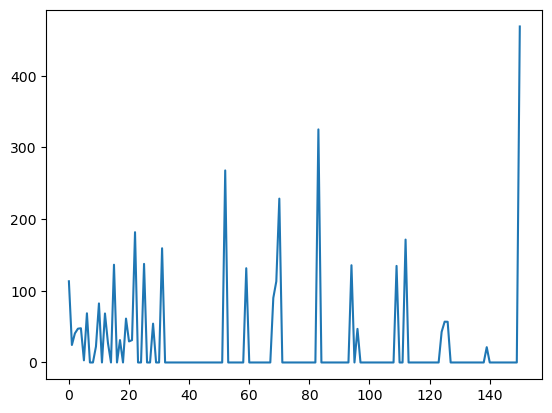

In [14]:
df['지하철접근도'].plot()

### 버스 접근도

In [15]:
bus_join =pd.read_csv("./data/2023년_버스노선별_정류장별_시간대별_승하차_인원_정보(03월).csv", encoding = "cp949")
col = [f'{i if i!=0 else "00"}시{j}총승객수' for i in range(24) for j in ['승차','하차']]
bus_join['총승하차승객수(일)'] = bus_join[col].sum(axis= 1)
bus_join.drop(columns = col, inplace = True)
bus_join['정류장'] = bus_join['역명'].apply(lambda x: re.search('[.\w]+',x).group())
bus_join

,사용년월,노선번호,노선명,표준버스정류장ID,버스정류장ARS번호,역명,교통수단타입코드,교통수단타입명,등록일자,총승하차승객수(일),정류장
0,202303,741,741번(진관차고지~헌인릉입구),100000001,1001,종로2가사거리(00077),10,서울간선버스,20230403,13413,종로2가사거리
1,202303,470,470번(상암차고지~안골마을),100000001,1001,종로2가사거리(00067),10,서울간선버스,20230403,15236,종로2가사거리
2,202303,N37,N37번(진관공영차고지~송파공영차고지),100000001,1001,종로2가사거리(00089),51,서울심야버스,20230403,686,종로2가사거리
3,202303,N37,N37번(송파공영차고지~진관공영차고지),100000001,1001,종로2가사거리(00032),51,서울심야버스,20230403,636,종로2가사거리
4,202303,100,100번(하계동~용산구청),100000002,1002,창경궁.서울대학교병원(00031),10,서울간선버스,20230403,8391,창경궁.서울대학교병원
...,...,...,...,...,...,...,...,...,...,...,...
41476,202303,6648,6648(방화동~양천구청),999800002,~,김포교통(종점가상)(00079),20,서울지선버스,20230403,9,김포교통
41477,202303,9404,9404번(분당구미~신사역),999800003,~,구미동차고지(기점가상)(00001),50,서울광역버스,20230403,49,구미동차고지
41478,202303,9404,9404번(분당구미~신사역),999800004,~,구미동차고지(종점가상)(00062),50,서울광역버스,20230403,77,구미동차고지
41479,202303,9701,9701번(가좌동~서울역),999800005,~,가좌동종점(종점가상)(00127),50,서울광역버스,20230403,44,가좌동종점


In [16]:
bus_data =pd.read_csv("./data/2022년_전국버스정류장 위치정보_데이터.csv", encoding = "cp949") 
bus = bus_data.copy()
bus = bus[bus['관리도시명']=='서울']
bus = bus[(bus['위도'] <= 37.598969+0.06) #서울시 강서구 북위 상한
    & (bus['위도'] >= 37.501022-0.06) #서울시 강서구 남위 하한
    & (bus['경도'] >= 126.795316-0.06) #서울시 강서구 서경 하한
    & (bus['경도'] <= 126.883285+0.06) #서울시 강서구 동경 상한
   ] # 0.06은 대략 500~700m 이고 강서구 외 다른 시나 구의 가까운 정류장도 탐색하기 위함
bus.index = np.arange(len(bus))
bus['표준버스정류장ID'] = bus['정류장번호'].str[3:]

# bus_join(노선, 유동인구 정보)와 기존 bus를 join
linecount = pd.DataFrame(bus_join.groupby('표준버스정류장ID').agg({'노선명': 'count', 
                                            '정류장': 'first','총승하차승객수(일)':'first'}))
linecount = linecount.rename(columns = {'노선명' : '노선수'})
linecount = linecount.reset_index()
linecount['표준버스정류장ID'] = linecount['표준버스정류장ID'].astype(str)
display(linecount)

# 둘의 데이터의 교집합을 이용하기위하여 inner 사용 -> left로 했을때 이상한 정류장도 같이 탐색됨
bus = pd.merge(left = bus, right = linecount, how = "inner", on = "표준버스정류장ID")
bus[bus['정류장'].isnull()]

bus["위경도"] = [(float(bus['위도'].values[i]),float(bus['경도'].values[i])) for i in range(len(bus))]

bus

,표준버스정류장ID,노선수,정류장,총승하차승객수(일)
0,100000001,4,종로2가사거리,13413
1,100000002,19,창경궁.서울대학교병원,8391
2,100000003,19,명륜3가.성대입구,297
3,100000004,7,종로2가.삼일교,270
4,100000005,18,혜화동로터리.여운형활동터,11563
...,...,...,...,...
12676,999800001,6,김포교통,169
12677,999800002,6,김포교통,23
12678,999800003,1,구미동차고지,49
12679,999800004,1,구미동차고지,77


,정류장번호,정류장명,위도,경도,정보수집일시,모바일단축번호,도시코드,도시명,관리도시명,표준버스정류장ID,노선수,정류장,총승하차승객수(일),위경도
0,SEB111000001,덕은교.은평차고지앞,37.589598,126.884114,2.022100e+13,12001.0,11,서울특별시,서울,111000001,9,덕은교.은평차고지앞,2328,"(37.5895977, 126.8841144)"
1,SEB111000002,덕은교.은평차고지앞,37.589165,126.884787,2.022100e+13,12002.0,11,서울특별시,서울,111000002,13,덕은교.은평차고지앞,1425,"(37.5891649, 126.8847866)"
2,SEB111000003,수색교,37.585785,126.888480,2.022100e+13,12003.0,11,서울특별시,서울,111000003,14,수색교,4364,"(37.5857849, 126.8884797)"
3,SEB111000004,수색교,37.584877,126.889819,2.022100e+13,12004.0,11,서울특별시,서울,111000004,15,수색교,2185,"(37.5848769, 126.8898192)"
4,SEB111000005,수색역앞,37.583223,126.893238,2.022100e+13,12005.0,11,서울특별시,서울,111000005,14,수색역앞,3853,"(37.583223, 126.893238)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4397,SEB219000452,호수마을(중),37.648481,126.780715,2.022100e+13,36696.0,11,서울특별시,서울,219000452,1,호수마을,4185,"(37.6484806, 126.7807155)"
4398,SEB219000453,흰돌마을(중),37.648137,126.781350,2.022100e+13,36684.0,11,서울특별시,서울,219000453,1,흰돌마을,5164,"(37.6481375, 126.7813499)"
4399,SEB219000454,알미공원(중),37.645742,126.784332,2.022100e+13,36701.0,11,서울특별시,서울,219000454,4,알미공원,5333,"(37.6457425, 126.7843323)"
4400,SEB219000657,어린이교통공원,37.643028,126.793989,2.022100e+13,36150.0,11,서울특별시,서울,219000657,1,어린이교통공원,1277,"(37.6430281, 126.7939895)"


In [17]:
df['버스접근도'] = np.nan
for j in range(len(df)): #공원 데이터를 돌면서
    temp_loc = park_loc[j]
    bus['distance'] = bus['위경도'].apply(lambda x: haversine(tuple(temp_loc),x, unit= 'm'))
    
    bus['버스접근도'] = np.nan
    bus['버스접근도'][bus['distance'] > df['유치거리'][j]] = 0
    bus['버스접근도'][bus['distance'] <= df['유치거리'][j]] = \
        (bus['총승하차승객수(일)'] * bus['노선수']) / (bus['distance'])
    
    df['버스접근도'][j] = bus['버스접근도'].sum()
df

,이름,구분,소재지지번주소,위도,경도,면적,유치거리,행정동명,id,보유시설수,지하철접근도,버스접근도
0,우장,근린공원,서울특별시 강서구 화곡동 산60-1,37.550402,126.843560,359435.2,1299.764574,우장산동,37.5504021_126.8435599,8,113.283549,4014.275526
1,궁산,근린공원,서울특별시 강서구 가양동 산4-7,37.574157,126.840799,135002.7,1183.713568,가양1동,37.5741566_126.8407987,3,24.445876,474.829441
2,염창,근린공원,서울특별시 강서구 염창동 산24-1,37.557901,126.868862,112070.0,1167.384288,염창동,37.5579009_126.8688619,2,40.586929,1469.282111
3,꿩고개,근린공원,서울특별시 강서구 방화동 산97-1,37.578157,126.816935,180000.0,1212.132034,방화3동,37.5781568_126.816935,2,47.148198,509.503938
4,봉제산,근린공원,서울특별시 강서구 화곡동 산1,37.541090,126.858626,917190.0,1478.850185,화곡4동,37.5410899_126.8586256,3,47.750486,4968.483990
...,...,...,...,...,...,...,...,...,...,...,...,...
146,놋다리,문화공원,서울특별시 강서구마곡동 790-6,37.561995,126.836352,2574.7,275.370751,가양1동,37.5619946_126.8363522,1,0.000000,32.020556
147,똘고랑,문화공원,서울특별시 강서구 마곡동 756-4,37.570689,126.827897,3089.9,277.793434,가양1동,37.5706894_126.8278971,1,0.000000,67.782030
148,선두암,문화공원,서울특별시 강서구 마곡동 778-4,37.567424,126.838138,2581.3,275.403248,가양1동,37.5674236_126.8381378,0,0.000000,253.406376
149,한다리,문화공원,서울특별시 강서구 마곡동 727-1038,37.560960,126.830528,8298.0,295.546679,가양1동,37.56096_126.8305285,0,0.000000,404.522610


<Axes: >

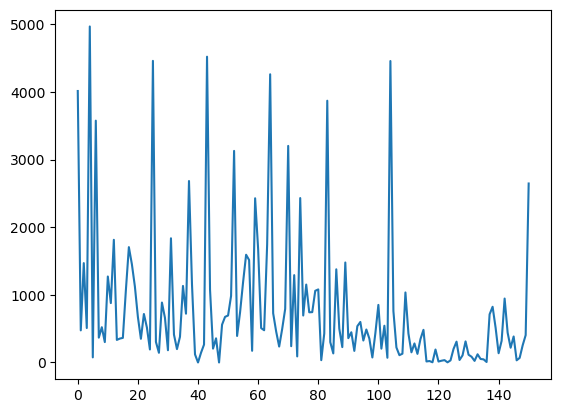

In [18]:
df['버스접근도'].plot()

### 유동인구 데이터

#### 공원 유치거리 내 거주인구

In [19]:
flow = pd.read_csv("./data/강서구_세부_유동인구_위경도변환.csv")
flow['위경도'] = flow['위경도'].apply(lambda x : tuple(re.findall("[.0-9]+" ,x)))
flow['위경도'] = flow['위경도'].apply(lambda x : (float(x[0]),float(x[1])))

In [20]:
temp_flow = flow[['총 인구','위경도']]

df['거주인구'] = np.nan
for j in range(len(df)): #공원 데이터를 돌면서
    temp_loc = park_loc[j]
    temp_flow['distance'] = temp_flow['위경도'].apply(lambda x: haversine(tuple(temp_loc),x, unit= 'm'))
    
    temp_flow['거주인구'] = np.nan
    temp_flow['거주인구'][temp_flow['distance'] > df['유치거리'][j]] = 0
    temp_flow['거주인구'][temp_flow['distance'] <= df['유치거리'][j]] = (temp_flow['총 인구'])
    
    df['거주인구'][j] = temp_flow['거주인구'].sum()
df

,이름,구분,소재지지번주소,위도,경도,면적,유치거리,행정동명,id,보유시설수,지하철접근도,버스접근도,거주인구
0,우장,근린공원,서울특별시 강서구 화곡동 산60-1,37.550402,126.843560,359435.2,1299.764574,우장산동,37.5504021_126.8435599,8,113.283549,4014.275526,150536.0
1,궁산,근린공원,서울특별시 강서구 가양동 산4-7,37.574157,126.840799,135002.7,1183.713568,가양1동,37.5741566_126.8407987,3,24.445876,474.829441,28182.0
2,염창,근린공원,서울특별시 강서구 염창동 산24-1,37.557901,126.868862,112070.0,1167.384288,염창동,37.5579009_126.8688619,2,40.586929,1469.282111,79120.0
3,꿩고개,근린공원,서울특별시 강서구 방화동 산97-1,37.578157,126.816935,180000.0,1212.132034,방화3동,37.5781568_126.816935,2,47.148198,509.503938,59873.0
4,봉제산,근린공원,서울특별시 강서구 화곡동 산1,37.541090,126.858626,917190.0,1478.850185,화곡4동,37.5410899_126.8586256,3,47.750486,4968.483990,212343.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,놋다리,문화공원,서울특별시 강서구마곡동 790-6,37.561995,126.836352,2574.7,275.370751,가양1동,37.5619946_126.8363522,1,0.000000,32.020556,1788.0
147,똘고랑,문화공원,서울특별시 강서구 마곡동 756-4,37.570689,126.827897,3089.9,277.793434,가양1동,37.5706894_126.8278971,1,0.000000,67.782030,1028.0
148,선두암,문화공원,서울특별시 강서구 마곡동 778-4,37.567424,126.838138,2581.3,275.403248,가양1동,37.5674236_126.8381378,0,0.000000,253.406376,3048.0
149,한다리,문화공원,서울특별시 강서구 마곡동 727-1038,37.560960,126.830528,8298.0,295.546679,가양1동,37.56096_126.8305285,0,0.000000,404.522610,1707.0


#### 행정동별 유동인구수

In [21]:
# 유동인구 데이터 : 이거 행정동별임.... 비율로 수정필요
data =pd.read_csv("./data/유동인구_total_행정동기준.csv")
df_b = data.copy()
df_b.columns = ['행정동명','유동인구수']
df_b['유동인구수'] = df_b['유동인구수']/(366+365+365+31+28)  #20년 1월 1일 ~ 23년 2월 28일 일 평균치

# 행정동별 유동인구를 df에 merge
df = pd.merge(left = df , right = df_b, how = "inner", on = "행정동명")

In [22]:
# (공원의 면적/행정동의 면적) 비율의 곱으로 유동인구 결정
keys = list(df_b['행정동명'].unique())
areas = [4.70,1.00,0.99,10.8,0.59,0.92,0.79,2.9,1.04,6.41,2.38,1.74,1.36,1.12,0.47,0.51,0.82,1.11,0.53,1.11]
area_dict = {}
for key, val in zip(keys, areas):
    area_dict[key] = val*1000000
area_dict
print(area_dict)

def area_partial(row):
    return float(row['면적'])/float(area_dict[row['행정동명']]) * row['유동인구수']

df['유동인구수'] = df.apply(area_partial, axis=1)
df

{'가양1동': 4700000.0, '가양2동': 1000000.0, '가양3동': 990000.0, '공항동': 10800000.0, '등촌1동': 590000.0, '등촌2동': 920000.0, '등촌3동': 790000.0, '발산1동': 2900000.0, '방화1동': 1040000.0, '방화2동': 6410000.0, '방화3동': 2380000.0, '염창동': 1740000.0, '우장산동': 1360000.0, '화곡1동': 1120000.0, '화곡2동': 470000.0, '화곡3동': 510000.0, '화곡4동': 820000.0, '화곡6동': 1110000.0, '화곡8동': 530000.0, '화곡본동': 1110000.0}


,이름,구분,소재지지번주소,위도,경도,면적,유치거리,행정동명,id,보유시설수,지하철접근도,버스접근도,거주인구,유동인구수
0,우장,근린공원,서울특별시 강서구 화곡동 산60-1,37.550402,126.843560,359435.2,1299.764574,우장산동,37.5504021_126.8435599,8,113.283549,4014.275526,150536.0,222947.323201
1,화곡2주구1,어린이공원,서울특별시 강서구 화곡동1159-2,37.550247,126.838677,2438.3,274.689573,우장산동,37.5502465_126.8386773,2,90.058362,495.819960,10863.0,1512.407405
2,화곡2주구2,어린이공원,서울특별시 강서구 화곡동1159-3,37.548740,126.838710,2438.2,274.689066,우장산동,37.5487397_126.8387097,3,113.225320,792.325737,12119.0,1512.345378
3,범바위,어린이공원,서울특별시 강서구 화곡동1061-36,37.543123,126.841565,973.6,265.601282,우장산동,37.5431228_126.8415652,1,228.612345,3202.411077,5488.0,603.896096
4,개나리,어린이공원,서울특별시 강서구 화곡동75-3,37.548391,126.844113,285.0,258.440972,우장산동,37.5483914_126.8441132,1,0.000000,240.862578,5809.0,176.777308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,배다리,어린이공원,서울특별시 강서구 화곡동341-24,37.532124,126.848315,1630.1,270.187248,화곡8동,37.5321238_126.8483151,1,325.183154,3870.586160,10120.0,2069.259174
147,안골,어린이공원,서울특별시 강서구 화곡동155-1,37.535793,126.850883,2381.8,274.401844,화곡8동,37.5357933_126.8508827,2,0.000000,301.057672,11176.0,3023.471873
148,대무,어린이공원,서울특별시 강서구 화곡동409-84,37.538098,126.847616,946.0,265.378556,화곡8동,37.538098_126.8476156,1,0.000000,134.303848,12000.0,1200.858339
149,모태,어린이공원,서울특별시 강서구 화곡동892-17,37.529512,126.849528,1003.4,265.838245,화곡8동,37.5295121_126.849528,1,0.000000,1377.501239,5780.0,1273.722259


## EDA & Visualization

In [23]:
center = park_loc[0]
g_map = folium.Map(location=park_loc[0], zoom_start=11, tiles='cartodbpositron')

for i in range(len(df)):
    folium.Marker(park_loc[i], popup = df['면적'][i],tooltip = df['이름'][i]).add_to(g_map)
for dong in dong_cordi:
    folium.GeoJson(data=dong_cordi[dong].__geo_interface__, tooltip = dong).add_to(g_map)
# g_map.save('output/map1.html')
g_map

In [24]:
# 전체 열 출력 시각화 되도록
pd.set_option('display.max_columns', None) 
df

,이름,구분,소재지지번주소,위도,경도,면적,유치거리,행정동명,id,보유시설수,지하철접근도,버스접근도,거주인구,유동인구수
0,우장,근린공원,서울특별시 강서구 화곡동 산60-1,37.550402,126.843560,359435.2,1299.764574,우장산동,37.5504021_126.8435599,8,113.283549,4014.275526,150536.0,222947.323201
1,화곡2주구1,어린이공원,서울특별시 강서구 화곡동1159-2,37.550247,126.838677,2438.3,274.689573,우장산동,37.5502465_126.8386773,2,90.058362,495.819960,10863.0,1512.407405
2,화곡2주구2,어린이공원,서울특별시 강서구 화곡동1159-3,37.548740,126.838710,2438.2,274.689066,우장산동,37.5487397_126.8387097,3,113.225320,792.325737,12119.0,1512.345378
3,범바위,어린이공원,서울특별시 강서구 화곡동1061-36,37.543123,126.841565,973.6,265.601282,우장산동,37.5431228_126.8415652,1,228.612345,3202.411077,5488.0,603.896096
4,개나리,어린이공원,서울특별시 강서구 화곡동75-3,37.548391,126.844113,285.0,258.440972,우장산동,37.5483914_126.8441132,1,0.000000,240.862578,5809.0,176.777308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,배다리,어린이공원,서울특별시 강서구 화곡동341-24,37.532124,126.848315,1630.1,270.187248,화곡8동,37.5321238_126.8483151,1,325.183154,3870.586160,10120.0,2069.259174
147,안골,어린이공원,서울특별시 강서구 화곡동155-1,37.535793,126.850883,2381.8,274.401844,화곡8동,37.5357933_126.8508827,2,0.000000,301.057672,11176.0,3023.471873
148,대무,어린이공원,서울특별시 강서구 화곡동409-84,37.538098,126.847616,946.0,265.378556,화곡8동,37.538098_126.8476156,1,0.000000,134.303848,12000.0,1200.858339
149,모태,어린이공원,서울특별시 강서구 화곡동892-17,37.529512,126.849528,1003.4,265.838245,화곡8동,37.5295121_126.849528,1,0.000000,1377.501239,5780.0,1273.722259


In [25]:
df.columns

Index(['이름', '구분', '소재지지번주소', '위도', '경도', '면적', '유치거리', '행정동명', 'id', '보유시설수',
       '지하철접근도', '버스접근도', '거주인구', '유동인구수'],
      dtype='object')

# 주위 공원 면적 종속 변수 만들기

In [26]:
# 공원 지적편집도 가져오기
green = pd.read_csv('./data/공원_지적편집도.csv')
green.columns

Index(['pnu', 'jibun', 'bchk', 'sgg_oid', 'col_adm_se', 'geometry', 'lat',
       'lon', 'polygon'],
      dtype='object')

In [27]:
green.head(3)

,pnu,jibun,bchk,sgg_oid,col_adm_se,geometry,lat,lon,polygon
0,1150010600107570002,757-2 공,1,143940,11500,POLYGON ((184318.99000000022 449685.7699999995...,37.549358,126.823570,[[ 37.54925344 126.8233539 ]\n [ 37.54949271 1...
1,1150010600107570004,757-4 공,1,143959,11500,POLYGON ((184253.51999999955 449642.9700000006...,37.548977,126.822976,[[ 37.5488667 126.82261397]\n [ 37.54889121 1...
2,1150010600107570006,757-6 공,1,143963,11500,"POLYGON ((184127.1900000004 449604.9600000009,...",37.548667,126.821848,[[ 37.54852206 126.82118525]\n [ 37.54850712 1...


In [28]:
import ast
import re
from shapely.geometry import Polygon

def create_polygon_list(df):
    polygon_list = []
    for i in range(len(df)):
        p = df['polygon'][i]
        # 문자열에서 숫자 사이에 쉼표 추가
        str_arr = re.sub(r'(?<=[0-9])\s+(?=[0-9])', ', ', p)
        # 숫자 사이에 , 추가
        str_coords = str_arr.replace('[ ', '[').replace('\n [', ',[').replace(' ]', ']').replace(']\n', '],')
        # 문자열을 리스트로 변환
        coords = ast.literal_eval(str_coords)
        # Polygon 객체 생성
        polygon = Polygon(coords)
        # Polygon 객체를 리스트에 추가
        polygon_list.append(polygon)
    return polygon_list

# Polygon 객체들을 담은 리스트 생성
polygon_list = create_polygon_list(green)

# 추가로 존재하는 주위 공원 면적 구하기
df['주위공원면적'] = 0

# 입력으로 받은 특정 polygon으로부터, 해당 주위 반경 X(m)에 해당하는 영역 내에 겹치는 다른 모든 polygon들의 넓이의 합을 구하는 함수
def calculate_intersection_area(row):
    center_point = Point(row['위도'], row['경도'])
    X = row['유치거리']
    
    # 입력으로 받은 중심 좌표를 기준으로, 특정 구한 X반경에 포함되는 다른 polygon들의 넓이 구하기
    total_intersection_area = 0
    for polygon in polygon_list:
        # polygon과 center_point 사이의 거리 계산
        distance_in_degrees = center_point.distance(polygon)
        # degrees to meters 변환 (평면 좌표계 기준)
        earth_radius_in_m = 6371000  # 지구 반지름 (단위: m)
        distance_in_m = distance_in_degrees * earth_radius_in_m * 2 * 3.141592 / 360

        # 거리가 X 이하인 경우, polygon과 입력으로 받은 polygon이 겹치는 영역 계산
        if distance_in_m <= X:
            intersection = polygon.intersection(center_point.buffer(X/111139))  # km/hour 에서 km/degree 변환을 위해 111,139m 사용
            intersection_area = intersection.area * (111139**2)  # degree 단위에서 m^2 단위로 변환
            total_intersection_area += intersection_area
    # print("총합 : ", total_intersection_area)
    # 구한 넓이의 총합을 리턴
    return total_intersection_area

In [29]:
# df의 모든 좌표에 대해 polygon 넓이 구해서 업데이트
df['주위공원면적'] = df.apply(calculate_intersection_area, axis=1)

In [30]:
df

,이름,구분,소재지지번주소,위도,경도,면적,유치거리,행정동명,id,보유시설수,지하철접근도,버스접근도,거주인구,유동인구수,주위공원면적
0,우장,근린공원,서울특별시 강서구 화곡동 산60-1,37.550402,126.843560,359435.2,1299.764574,우장산동,37.5504021_126.8435599,8,113.283549,4014.275526,150536.0,222947.323201,578586.830799
1,화곡2주구1,어린이공원,서울특별시 강서구 화곡동1159-2,37.550247,126.838677,2438.3,274.689573,우장산동,37.5502465_126.8386773,2,90.058362,495.819960,10863.0,1512.407405,38417.459241
2,화곡2주구2,어린이공원,서울특별시 강서구 화곡동1159-3,37.548740,126.838710,2438.2,274.689066,우장산동,37.5487397_126.8387097,3,113.225320,792.325737,12119.0,1512.345378,18541.297678
3,범바위,어린이공원,서울특별시 강서구 화곡동1061-36,37.543123,126.841565,973.6,265.601282,우장산동,37.5431228_126.8415652,1,228.612345,3202.411077,5488.0,603.896096,4751.017563
4,개나리,어린이공원,서울특별시 강서구 화곡동75-3,37.548391,126.844113,285.0,258.440972,우장산동,37.5483914_126.8441132,1,0.000000,240.862578,5809.0,176.777308,82844.055853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,배다리,어린이공원,서울특별시 강서구 화곡동341-24,37.532124,126.848315,1630.1,270.187248,화곡8동,37.5321238_126.8483151,1,325.183154,3870.586160,10120.0,2069.259174,2053.716234
147,안골,어린이공원,서울특별시 강서구 화곡동155-1,37.535793,126.850883,2381.8,274.401844,화곡8동,37.5357933_126.8508827,2,0.000000,301.057672,11176.0,3023.471873,3818.664300
148,대무,어린이공원,서울특별시 강서구 화곡동409-84,37.538098,126.847616,946.0,265.378556,화곡8동,37.538098_126.8476156,1,0.000000,134.303848,12000.0,1200.858339,1529.163785
149,모태,어린이공원,서울특별시 강서구 화곡동892-17,37.529512,126.849528,1003.4,265.838245,화곡8동,37.5295121_126.849528,1,0.000000,1377.501239,5780.0,1273.722259,1251.774830


In [31]:
df.columns

Index(['이름', '구분', '소재지지번주소', '위도', '경도', '면적', '유치거리', '행정동명', 'id', '보유시설수',
       '지하철접근도', '버스접근도', '거주인구', '유동인구수', '주위공원면적'],
      dtype='object')

In [32]:
X = df[['면적','유치거리','지하철접근도','버스접근도','유동인구수','거주인구']]
y = df[['주위공원면적']]
X

,면적,유치거리,지하철접근도,버스접근도,유동인구수,거주인구
0,359435.2,1299.764574,113.283549,4014.275526,222947.323201,150536.0
1,2438.3,274.689573,90.058362,495.819960,1512.407405,10863.0
2,2438.2,274.689066,113.225320,792.325737,1512.345378,12119.0
3,973.6,265.601282,228.612345,3202.411077,603.896096,5488.0
4,285.0,258.440972,0.000000,240.862578,176.777308,5809.0
...,...,...,...,...,...,...
146,1630.1,270.187248,325.183154,3870.586160,2069.259174,10120.0
147,2381.8,274.401844,0.000000,301.057672,3023.471873,11176.0
148,946.0,265.378556,0.000000,134.303848,1200.858339,12000.0
149,1003.4,265.838245,0.000000,1377.501239,1273.722259,5780.0


In [33]:
# 데이터 표준화
scaler = StandardScaler()
standardized_data = scaler.fit_transform(X)

# PCA 적용
pca = PCA(n_components=5)  # 축소할 차원 수를 설정합니다. 예제에서는 4차원으로 축소합니다.
pca_data = pca.fit_transform(standardized_data)

print(pca_data)

[[ 9.47805941e+00  6.21998238e-01  4.30265153e-01 -3.86318962e-02
  -1.35835478e+00]
 [-3.40417632e-01  7.37356608e-01 -6.70450082e-01  4.22181599e-01
  -2.02885518e-01]
 [-1.91543592e-01  1.17663958e+00 -6.88117878e-01  4.06730572e-01
  -2.10041469e-01]
 [ 5.16310428e-01  3.94067979e+00 -1.75079991e-01  9.53854467e-02
   3.04237542e-01]
 [-7.27092543e-01 -4.51271885e-01  9.72616977e-04  2.17480333e-01
  -2.82387252e-02]
 [-2.77564736e-01  9.24826592e-02  6.47766445e-01 -1.49929863e-01
   1.04436331e-01]
 [-6.06241522e-01 -5.75547748e-01 -1.21564705e-01  2.26215665e-01
  -1.59735341e-01]
 [-7.31183652e-01 -5.57680934e-01 -1.19195767e-01  2.55554995e-01
  -8.45538703e-02]
 [ 5.21920275e-01  1.87603981e+00  2.69808938e+00 -1.14510537e+00
   7.37606204e-01]
 [-4.51250277e-01 -1.89640856e-01  3.25803436e-01  1.64245707e-02
  -6.82510343e-02]
 [ 2.42177351e+00 -1.03471946e+00 -1.56857966e+00 -1.46227480e+00
   7.91827125e-01]
 [ 2.07482256e-01 -6.81355217e-01 -4.42472600e-01 -5.44690720e-01

In [34]:
X = sm.add_constant(pca_data, has_constant = "add")

In [35]:
multi_model = sm.OLS(y,X)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 주위공원면적   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     44.50
Date:                Fri, 21 Apr 2023   Prob (F-statistic):           1.18e-27
Time:                        03:22:46   Log-Likelihood:                -1892.6
No. Observations:                 151   AIC:                             3797.
Df Residuals:                     145   BIC:                             3815.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.793e+04   5579.132      6.799      0.000    2.69e+04     4.9e+04
x1           3.15e+04   2920.061     10.786      0.000    2.57e+04    3.73e+04
x2          -1.42e+04   4941.358     -2.873      0.005    -2.4e+04   -4430.418
x3         -4.923e+04   7691.888     -6.400      0.000   -6.44e+04    -3.4e+04
x4         -6.396e+04   9135.285     -7.002      0.000    -8.2e+04   -4.59e+04
x5          3.948e+04    1.4e+04      2.817      0.006    1.18e+04    6.72e+04
==============================================================================
Omnibus:                      101.205   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2918.802
Skew:                           1.786   Prob(JB):                         0.00
Kurtosis:                      24.240   Cond. No.                         4.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
fitted_multi_model.params

const    37934.924520
x1       31495.221698
x2      -14196.811697
x3      -49231.802830
x4      -63963.617676
x5       39478.859305
dtype: float64

In [37]:
df.corr()

,위도,경도,면적,유치거리,보유시설수,지하철접근도,버스접근도,거주인구,유동인구수,주위공원면적
위도,1.000000,-0.540840,0.074243,0.208340,0.139918,-0.036795,-0.328938,-0.049988,-0.033798,0.210239
경도,-0.540840,1.000000,0.015263,-0.012142,0.031238,0.088335,0.308525,0.127135,0.091094,-0.072866
면적,0.074243,0.015263,1.000000,0.758025,0.351142,0.077557,0.336897,0.817241,0.925620,0.527845
유치거리,0.208340,-0.012142,0.758025,1.000000,0.496987,0.086503,0.266518,0.796872,0.624365,0.762963
보유시설수,0.139918,0.031238,0.351142,0.496987,1.000000,0.005757,0.147389,0.395512,0.321609,0.517984
지하철접근도,-0.036795,0.088335,0.077557,0.086503,0.005757,1.000000,0.449730,0.113548,0.089626,0.078320
버스접근도,-0.328938,0.308525,0.336897,0.266518,0.147389,0.449730,1.000000,0.453264,0.417721,0.132829
거주인구,-0.049988,0.127135,0.817241,0.796872,0.395512,0.113548,0.453264,1.000000,0.878038,0.517391
유동인구수,-0.033798,0.091094,0.925620,0.624365,0.321609,0.089626,0.417721,0.878038,1.000000,0.379189
주위공원면적,0.210239,-0.072866,0.527845,0.762963,0.517984,0.078320,0.132829,0.517391,0.379189,1.000000


In [38]:
params = fitted_multi_model.params
params

const    37934.924520
x1       31495.221698
x2      -14196.811697
x3      -49231.802830
x4      -63963.617676
x5       39478.859305
dtype: float64

In [39]:
X = pd.DataFrame(X)
X

,0,1,2,3,4,5
0,1.0,9.478059,0.621998,0.430265,-0.038632,-1.358355
1,1.0,-0.340418,0.737357,-0.670450,0.422182,-0.202886
2,1.0,-0.191544,1.176640,-0.688118,0.406731,-0.210041
3,1.0,0.516310,3.940680,-0.175080,0.095385,0.304238
4,1.0,-0.727093,-0.451272,0.000973,0.217480,-0.028239
...,...,...,...,...,...,...
146,1.0,0.994739,5.449465,-0.618360,0.221341,0.192982
147,1.0,-0.533298,-0.457831,0.028445,0.175187,-0.162040
148,1.0,-0.605603,-0.540575,-0.069187,0.221745,-0.229392
149,1.0,-0.384510,0.173631,0.725882,-0.146972,0.188628


In [40]:
value = X[0]*params[0]
for i in range(1,6): value += X[i]*params[i]
df['value'] = value
df

,이름,구분,소재지지번주소,위도,경도,면적,유치거리,행정동명,id,보유시설수,지하철접근도,버스접근도,거주인구,유동인구수,주위공원면적,value
0,우장,근린공원,서울특별시 강서구 화곡동 산60-1,37.550402,126.843560,359435.2,1299.764574,우장산동,37.5504021_126.8435599,8,113.283549,4014.275526,150536.0,222947.323201,578586.830799,255280.124354
1,화곡2주구1,어린이공원,서울특별시 강서구 화곡동1159-2,37.550247,126.838677,2438.3,274.689573,우장산동,37.5502465_126.8386773,2,90.058362,495.819960,10863.0,1512.407405,38417.459241,14738.797814
2,화곡2주구2,어린이공원,서울특별시 강서구 화곡동1159-3,37.548740,126.838710,2438.2,274.689066,우장산동,37.5487397_126.8387097,3,113.225320,792.325737,12119.0,1512.345378,18541.297678,14766.813392
3,범바위,어린이공원,서울특별시 강서구 화곡동1061-36,37.543123,126.841565,973.6,265.601282,우장산동,37.5431228_126.8415652,1,228.612345,3202.411077,5488.0,603.896096,4751.017563,12780.403451
4,개나리,어린이공원,서울특별시 강서구 화곡동75-3,37.548391,126.844113,285.0,258.440972,우장산동,37.5483914_126.8441132,1,0.000000,240.862578,5809.0,176.777308,82844.055853,6368.060454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,배다리,어린이공원,서울특별시 강서구 화곡동341-24,37.532124,126.848315,1630.1,270.187248,화곡8동,37.5321238_126.8483151,1,325.183154,3870.586160,10120.0,2069.259174,2053.716234,15803.347901
147,안골,어린이공원,서울특별시 강서구 화곡동155-1,37.535793,126.850883,2381.8,274.401844,화곡8동,37.5357933_126.8508827,2,0.000000,301.057672,11176.0,3023.471873,3818.664300,8635.205578
148,대무,어린이공원,서울특별시 강서구 화곡동409-84,37.538098,126.847616,946.0,265.378556,화곡8동,37.538098_126.8476156,1,0.000000,134.303848,12000.0,1200.858339,1529.163785,6702.171438
149,모태,어린이공원,서울특별시 강서구 화곡동892-17,37.529512,126.849528,1003.4,265.838245,화곡8동,37.5295121_126.849528,1,0.000000,1377.501239,5780.0,1273.722259,1251.774830,4470.906136


In [41]:
# 데이터 저장 : 둘이 같은 것을 의미하니 이름혼동하지 말것
df.to_csv("../그래프/강서구_공원데이터_0420.csv")
df.to_csv('./data/공원_최종.csv')

In [42]:
# import folium
# from shapely.geometry import Polygon

# # 첫 번째 polygon
# poly1_coords = [(37.541, 126.986), (37.541, 126.991), (37.546, 126.991), (37.546, 126.986)]
# poly1 = Polygon(poly1_coords)

# # 두 번째 polygon
# poly2_coords = [(37.544, 126.989), (37.544, 126.994), (37.549, 126.994), (37.549, 126.989)]
# poly2 = Polygon(poly2_coords)

# # folium 지도 생성
# m = folium.Map(location=[37.545, 126.989], zoom_start=15)

# # 첫 번째 polygon을 folium 지도에 추가
# folium.Polygon(
#     locations=poly1_coords,
#     color='blue',
#     fill=True,
#     fill_color='blue',
#     fill_opacity=0.4
# ).add_to(m)

# # 두 번째 polygon을 folium 지도에 추가
# folium.Polygon(
#     locations=poly2_coords,
#     color='red',
#     fill=True,
#     fill_color='red',
#     fill_opacity=0.4
# ).add_to(m)

# # 두 polygon의 교집합 계산
# intersection = poly1.intersection(poly2)
# intersection_coords = list(intersection.exterior.coords)

# # 교집합을 folium 지도에 추가
# folium.Polygon(
#     locations=intersection_coords,
#     color='green',
#     fill=True,
#     fill_color='green',
#     fill_opacity=0.4
# ).add_to(m)

# # 교집합 면적 계산
# intersection_area = intersection.area

# # folium 지도 출력
# m
